# Classificação Binária Cachorro vs Gato com Logic Tensor Networks (LTN)

Este notebook implementa um sistema de classificação neuro-simbólico usando LTN para distinguir entre imagens de cachorros e gatos, combinando redes neurais com raciocínio lógico.

## Fundamentos das Logic Tensor Networks

### O que são LTNs?
As Logic Tensor Networks representam uma abordagem híbrida que une:
- **Aprendizado Profundo**: Capacidade de extrair padrões complexos de dados
- **Raciocínio Lógico**: Estruturas formais para representar conhecimento

### Arquitetura Neuro-Simbólica
O framework permite definir axiomas lógicos como função de perda, onde:
- Constantes → Tensores (embeddings de objetos)
- Predicados → Redes Neurais (retornam probabilidades [0,1])  
- Operadores Lógicos → Funções Fuzzy diferenciáveis

### Lógica Fuzzy para Diferenciabilidade
Substituímos operadores booleanos por versões contínuas:
- **AND**: $u \cdot v$ (produto)
- **OR**: $u + v - u \cdot v$ (soma probabilística)
- **NOT**: $1 - u$ (complemento)
- **IMPLIES**: $1 - u + u \cdot v$ (implicação de Reichenbach)

In [1]:
# Instalar dependências necessárias
%pip install LTNtorch torchvision matplotlib

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


## Arquitetura da Rede Neural Convolucional

Vamos construir uma CNN que servirá como predicado lógico, retornando a probabilidade de uma imagem ser um cachorro.

Código 01

In [1]:
%pip uninstall ltn -y
%pip uninstall LTNtorch -y

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
%pip install LTNtorch 

  Using cached LTNtorch-1.0.2-py3-none-any.whl.metadata (13 kB)
  Using cached numpy-2.3.5-cp312-cp312-manylinux_2_27_x86_64.manylinux_2_28_x86_64.whl.metadata (62 kB)
  Using cached torch-2.9.1-cp312-cp312-manylinux_2_28_x86_64.whl.metadata (30 kB)
  Using cached filelock-3.20.1-py3-none-any.whl.metadata (2.1 kB)
  Using cached typing_extensions-4.15.0-py3-none-any.whl.metadata (3.3 kB)
  Using cached setuptools-80.9.0-py3-none-any.whl.metadata (6.6 kB)
  Using cached sympy-1.14.0-py3-none-any.whl.metadata (12 kB)
  Using cached networkx-3.6.1-py3-none-any.whl.metadata (6.8 kB)
  Using cached jinja2-3.1.6-py3-none-any.whl.metadata (2.9 kB)
  Using cached fsspec-2025.12.0-py3-none-any.whl.metadata (10 kB)
  Using cached nvidia_cuda_nvrtc_cu12-12.8.93-py3-none-manylinux2010_x86_64.manylinux_2_12_x86_64.whl.metadata (1.7 kB)
  Using cached nvidia_cuda_runtime_cu12-12.8.90-py3-none-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (1.7 kB)
  Using cached nvidia_cuda_cupti_cu12-12.8.

In [4]:
# Instalação da versão CPU-only (mais leve) para resolver o problema de espaço
%pip install torch torchvision --index-url https://download.pytorch.org/whl/cpu
%pip install LTNtorch --no-deps
%pip install matplotlib numpy

Looking in indexes: https://download.pytorch.org/whl/cpu
  Using cached sympy-1.14.0-py3-none-any.whl.metadata (12 kB)
  Using cached networkx-3.6.1-py3-none-any.whl.metadata (6.8 kB)
  Using cached fsspec-2025.12.0-py3-none-any.whl.metadata (10 kB)
  Using cached numpy-2.3.5-cp312-cp312-manylinux_2_27_x86_64.manylinux_2_28_x86_64.whl.metadata (62 kB)
  Using cached pillow-12.0.0-cp312-cp312-manylinux_2_27_x86_64.manylinux_2_28_x86_64.whl.metadata (8.8 kB)
  Using cached mpmath-1.3.0-py3-none-any.whl.metadata (8.6 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.4/184.4 MB 5.5 MB/s  0:00:33m0:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 8.1 MB/s  0:00:00 eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 5.2 MB/s  0:00:00 eta 0:00:01
Using cached pillow-12.0.0-cp312-cp312-manylinux_2_27_x86_64.manylinux_2_28_x86_64.whl (7.0 MB)
Using cached sympy-1.14.0-py3-none-any.whl (6.3 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 536.2/536.2 kB 5.1 MB/s 

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import ltn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import random
import numpy as np
import matplotlib.pyplot as plt

# Configura o LTNtorch para usar o dispositivo (GPU se disponível)
ltn.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Usando dispositivo: {ltn.device}")

# Hiperparâmetros de Imagem
RESOLUCAO_IMAGEM = 64 # Redimensionar imagens para 64x64
BATCH_SIZE = 32

Usando dispositivo: cpu


In [10]:
class RedeConvolutionalBinaria(nn.Module):
    """
    Arquitetura CNN especializada para classificação binária cachorro/gato.
    Retorna scores entre [0,1] compatíveis com lógica fuzzy.
    """
    def __init__(self):
        super(RedeConvolutionalBinaria, self).__init__()
        
        # Extrator de características hierárquico
        self.extrator_1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.extrator_2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)  
        self.extrator_3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        
        # Redução dimensional espacial
        self.pooling = nn.MaxPool2d(2, 2)
        
        # Camadas de decisão final
        # Após 3 pools: 64 -> 32 -> 16 -> 8, então 64 * 8 * 8 = 4096
        self.decisor_1 = nn.Linear(64 * 8 * 8, 128)
        self.decisor_2 = nn.Linear(128, 1)  # Saída única: probabilidade de ser cachorro
        
        # Funções de ativação
        self.ativacao = nn.ReLU()
        self.fuzzy_output = nn.Sigmoid()  # Garante [0,1] para compatibilidade LTN

    def forward(self, entrada_img):
        # Pipeline de extração de características
        x = self.pooling(self.ativacao(self.extrator_1(entrada_img)))
        x = self.pooling(self.ativacao(self.extrator_2(x)))
        x = self.pooling(self.ativacao(self.extrator_3(x)))
        
        # Linearização e classificação
        x = x.view(-1, 64 * 8 * 8)
        x = self.ativacao(self.decisor_1(x))
        x = self.decisor_2(x)
        
        # Saída fuzzy para LTN
        return self.fuzzy_output(x)

## Preparação dos Dados de Treinamento

Código 02

In [11]:
RESOLUCAO_IMAGEM = 64 

# Pipeline de transformação e normalização de imagens
transformacao_dados = transforms.Compose([
    transforms.Resize((RESOLUCAO_IMAGEM, RESOLUCAO_IMAGEM)),  # Padronização de tamanho
    transforms.ToTensor(),  # Conversão para tensor PyTorch
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalização ImageNet
])

# Caminho para o conjunto de dados
caminho_dataset = './PetImages'

try:
    # Carregamento do dataset estruturado em pastas por classe
    dataset_completo = datasets.ImageFolder(root=caminho_dataset, transform=transformacao_dados)
    mapeamento_classes = dataset_completo.class_to_idx
    print(f"Classes identificadas no dataset: {mapeamento_classes}")
    
    # Criação do carregador de dados com embaralhamento
    carregador_dados = DataLoader(
        dataset_completo, 
        batch_size=BATCH_SIZE, 
        shuffle=True,
        num_workers=2,  # Paralelização para performance
        pin_memory=True if torch.cuda.is_available() else False
    )
    
    print(f"Dataset carregado com sucesso!")
    print(f"Total de amostras: {len(dataset_completo)}")
    print(f"Batches por época: {len(carregador_dados)}")
    
except FileNotFoundError:
    print(f"ERRO: Dataset não encontrado no caminho: {caminho_dataset}")
    print("Certifique-se de que a estrutura de pastas está correta:")
    print("./PetImages/Cat/")
    print("./PetImages/Dog/")
    carregador_dados = None

Classes identificadas no dataset: {'Cat': 0, 'Dog': 1}
Dataset carregado com sucesso!
Total de amostras: 24998
Batches por época: 782


## Configuração do Sistema LTN

Código 03

In [12]:
# Instanciação da arquitetura neural como predicado lógico
modelo_cnn = RedeConvolutionalBinaria().to(ltn.device)

# Definição do predicado principal: "É Cachorro?"
# Este predicado mapeia imagens para probabilidades [0,1] 
EhCachorro = ltn.Predicate(modelo_cnn)

print("Predicado 'EhCachorro' definido com sucesso!")
print(f"Parâmetros treináveis: {sum(p.numel() for p in EhCachorro.parameters() if p.requires_grad):,}")

# Definição dos operadores lógicos fuzzy
OperadorNao = ltn.Connective(ltn.fuzzy_ops.NotStandard())  # Negação: 1 - x
QuantificadorUniversal = ltn.Quantifier(  # Para todo: agregação por p-mean
    ltn.fuzzy_ops.AggregPMeanError(p=2), 
    quantifier="f"
)

# Agregador de satisfação para múltiplos axiomas
AgregadorSatisfacao = ltn.fuzzy_ops.SatAgg()

print("Componentes lógicos LTN configurados:")
print("✓ Predicado: EhCachorro(x)")  
print("✓ Operador: ¬ (Não)")
print("✓ Quantificador: ∀ (Para todo)")
print("✓ Agregador de satisfação")

Predicado 'EhCachorro' definido com sucesso!
Parâmetros treináveis: 548,129
Componentes lógicos LTN configurados:
✓ Predicado: EhCachorro(x)
✓ Operador: ¬ (Não)
✓ Quantificador: ∀ (Para todo)
✓ Agregador de satisfação


In [13]:
# Configuração do otimizador para aprendizado baseado em lógica
otimizador = optim.Adam(
    EhCachorro.parameters(),  # Apenas os parâmetros da CNN são otimizados
    lr=0.001,                 # Taxa de aprendizado conservadora
    weight_decay=1e-4         # Regularização L2 para evitar overfitting
)

# Scheduler para decaimento da taxa de aprendizado
scheduler = optim.lr_scheduler.StepLR(otimizador, step_size=20, gamma=0.5)

print("Otimização configurada:")
print(f"✓ Otimizador: Adam (lr=0.001)")
print(f"✓ Regularização: L2 (weight_decay=1e-4)")
print(f"✓ Scheduler: StepLR (decay a cada 20 épocas)")

Otimização configurada:
✓ Otimizador: Adam (lr=0.001)
✓ Regularização: L2 (weight_decay=1e-4)
✓ Scheduler: StepLR (decay a cada 20 épocas)


## Treinamento Neuro-Simbólico

Código 04

In [14]:
# Suprimir warnings de imagens corrompidas (opcional)
import warnings
warnings.filterwarnings('ignore', category=UserWarning, module='PIL')
print("Warnings do PIL suprimidos para uma saída mais limpa.")

Warnings do PIL suprimidos para uma saída mais limpa.


In [15]:
# Configurações de treinamento
EPOCAS_TOTAL = 40
historico_satisfacao = []
historico_perda = []

print("=== INICIANDO TREINAMENTO NEURO-SIMBÓLICO ===\n")
print("Base de Conhecimento definida:")
print("Axioma 1: ∀x ∈ Cachorros → EhCachorro(x)")
print("Axioma 2: ∀x ∈ Gatos → ¬EhCachorro(x)")
print("\nMétricas por época:")
print("Época | Satisfação | Perda    | Taxa Aprend.")
print("------|-----------|----------|------------")

for epoca in range(EPOCAS_TOTAL):
    perda_epoca = 0.0
    satisfacao_epoca = 0.0
    batches_validos = 0
    
    # Colocar modelo em modo de treinamento
    EhCachorro.train()
    
    for idx_batch, (imagens_batch, labels_batch) in enumerate(carregador_dados):
        if carregador_dados is None:
            print("Dataset não carregado. Abortando treinamento.")
            break
            
        # Transferir dados para dispositivo computacional
        imagens_batch = imagens_batch.to(ltn.device)
        labels_batch = labels_batch.to(ltn.device)
        
        # Separação lógica das amostras por classe
        # Assumindo: 0=gatos, 1=cachorros (baseado no ImageFolder)
        mascara_cachorros = (labels_batch == 1)
        mascara_gatos = (labels_batch == 0)
        
        imgs_cachorros = imagens_batch[mascara_cachorros]
        imgs_gatos = imagens_batch[mascara_gatos]
        
        # Verificar se ambas as classes estão presentes no batch
        if len(imgs_cachorros) == 0 or len(imgs_gatos) == 0:
            continue  # Skip batches with only one class
            
        # ATERRAMENTO: Criação das variáveis lógicas LTN
        var_cachorros = ltn.Variable("cachorros", imgs_cachorros)
        var_gatos = ltn.Variable("gatos", imgs_gatos)
        
        # DEFINIÇÃO DOS AXIOMAS LÓGICOS
        # Axioma 1: Todas as imagens de cachorro devem ser classificadas como cachorro
        axioma_positivo = QuantificadorUniversal(var_cachorros, EhCachorro(var_cachorros))
        
        # Axioma 2: Todas as imagens de gato devem ser classificadas como NÃO cachorro  
        axioma_negativo = QuantificadorUniversal(var_gatos, OperadorNao(EhCachorro(var_gatos)))
        
        # CÁLCULO DA SATISFAÇÃO AGREGADA
        nivel_satisfacao = AgregadorSatisfacao(axioma_positivo, axioma_negativo)
        
        # FUNÇÃO DE PERDA: Maximizar satisfação = Minimizar (1 - satisfação)
        perda_logica = 1.0 - nivel_satisfacao
        
        # BACKPROPAGATION E OTIMIZAÇÃO
        otimizador.zero_grad()    # Limpar gradientes anteriores
        perda_logica.backward()   # Calcular gradientes
        
        # Gradient clipping para estabilidade
        torch.nn.utils.clip_grad_norm_(EhCachorro.parameters(), max_norm=1.0)
        
        otimizador.step()         # Atualizar pesos
        
        # Acumular métricas
        perda_epoca += perda_logica.item()
        satisfacao_epoca += nivel_satisfacao.item()
        batches_validos += 1
    
    # Atualizar taxa de aprendizado
    scheduler.step()
    
    # Calcular médias da época
    if batches_validos > 0:
        perda_media = perda_epoca / batches_validos
        satisfacao_media = satisfacao_epoca / batches_validos
        
        # Armazenar histórico
        historico_perda.append(perda_media)
        historico_satisfacao.append(satisfacao_media)
        
        # Exibir progresso
        taxa_atual = scheduler.get_last_lr()[0]
        print(f"{epoca+1:5d} | {satisfacao_media:8.4f}  | {perda_media:7.4f}  | {taxa_atual:.2e}")
        
        # Early stopping baseado em satisfação
        if satisfacao_media > 0.95 and epoca > 20:
            print(f"\nConvergência atingida na época {epoca+1}!")
            print(f"Satisfação final: {satisfacao_media:.4f}")
            break
    else:
        print(f"Época {epoca+1}: Nenhum batch válido processado")

print("\n=== TREINAMENTO CONCLUÍDO ===")
print(f"Melhor satisfação alcançada: {max(historico_satisfacao):.4f}")
print(f"Menor perda registrada: {min(historico_perda):.4f}")

=== INICIANDO TREINAMENTO NEURO-SIMBÓLICO ===

Base de Conhecimento definida:
Axioma 1: ∀x ∈ Cachorros → EhCachorro(x)
Axioma 2: ∀x ∈ Gatos → ¬EhCachorro(x)

Métricas por época:
Época | Satisfação | Perda    | Taxa Aprend.
------|-----------|----------|------------


    1 |   0.5835  |  0.4165  | 1.00e-03
    2 |   0.6376  |  0.3624  | 1.00e-03
    3 |   0.6676  |  0.3324  | 1.00e-03
    4 |   0.6888  |  0.3112  | 1.00e-03
    5 |   0.7051  |  0.2949  | 1.00e-03
    6 |   0.7204  |  0.2796  | 1.00e-03
    7 |   0.7378  |  0.2622  | 1.00e-03
    8 |   0.7547  |  0.2453  | 1.00e-03
    9 |   0.7718  |  0.2282  | 1.00e-03
   10 |   0.7893  |  0.2107  | 1.00e-03
   11 |   0.8025  |  0.1975  | 1.00e-03
   12 |   0.8159  |  0.1841  | 1.00e-03
   13 |   0.8297  |  0.1703  | 1.00e-03
   14 |   0.8345  |  0.1655  | 1.00e-03
   15 |   0.8432  |  0.1568  | 1.00e-03
   16 |   0.8507  |  0.1493  | 1.00e-03
   17 |   0.8563  |  0.1437  | 1.00e-03
   18 |   0.8623  |  0.1377  | 1.00e-03
   19 |   0.8618  |  0.1382  | 1.00e-03
   20 |   0.8651  |  0.1349  | 5.00e-04
   21 |   0.9185  |  0.0815  | 5.00e-04
   22 |   0.9359  |  0.0641  | 5.00e-04
   23 |   0.9443  |  0.0557  | 5.00e-04
   24 |   0.9488  |  0.0512  | 5.00e-04
   25 |   0.9522  |  0.0478  | 5.00e-04


## Análise dos Resultados

Código 05

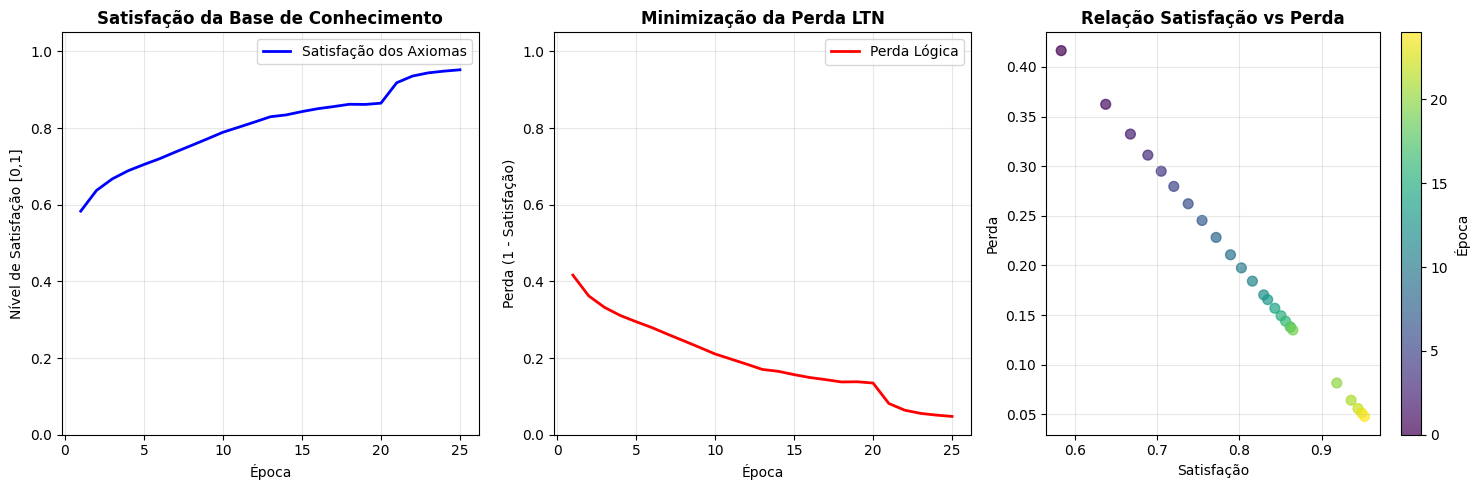

=== ANÁLISE DE CONVERGÊNCIA ===
Satisfação inicial: 0.5835
Satisfação final: 0.9522
Melhoria total: 0.3687
Taxa de convergência: 0.014750 por época
EXCELENTE


In [18]:
# Visualização do progresso de treinamento
plt.figure(figsize=(15, 5))

# Gráfico 1: Evolução da Satisfação Lógica
plt.subplot(1, 3, 1)
plt.plot(range(1, len(historico_satisfacao)+1), historico_satisfacao, 'b-', linewidth=2, label='Satisfação dos Axiomas')
plt.title('Satisfação da Base de Conhecimento', fontsize=12, fontweight='bold')
plt.xlabel('Época')
plt.ylabel('Nível de Satisfação [0,1]')
plt.grid(True, alpha=0.3)
plt.ylim(0, 1.05)
plt.legend()

# Gráfico 2: Redução da Perda
plt.subplot(1, 3, 2)
plt.plot(range(1, len(historico_perda)+1), historico_perda, 'r-', linewidth=2, label='Perda Lógica')
plt.title('Minimização da Perda LTN', fontsize=12, fontweight='bold')
plt.xlabel('Época')
plt.ylabel('Perda (1 - Satisfação)')
plt.grid(True, alpha=0.3)
plt.ylim(0, 1.05)
plt.legend()

# Gráfico 3: Correlação Inversa Satisfação-Perda
plt.subplot(1, 3, 3)
plt.scatter(historico_satisfacao, historico_perda, c=range(len(historico_satisfacao)), 
           cmap='viridis', s=50, alpha=0.7)
plt.title('Relação Satisfação vs Perda', fontsize=12, fontweight='bold')
plt.xlabel('Satisfação')
plt.ylabel('Perda')
plt.colorbar(label='Época')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Estatísticas finais
if len(historico_satisfacao) > 0:
    print("=== ANÁLISE DE CONVERGÊNCIA ===")
    print(f"Satisfação inicial: {historico_satisfacao[0]:.4f}")
    print(f"Satisfação final: {historico_satisfacao[-1]:.4f}")
    print(f"Melhoria total: {historico_satisfacao[-1] - historico_satisfacao[0]:.4f}")
    print(f"Taxa de convergência: {(historico_satisfacao[-1] - historico_satisfacao[0])/len(historico_satisfacao):.6f} por época")
    
    # Verificar qualidade do aprendizado lógico
    satisfacao_final = historico_satisfacao[-1]
    if satisfacao_final > 0.9:
        print("EXCELENTE")
    elif satisfacao_final > 0.8:
        print("BOM")
    elif satisfacao_final > 0.7:
        print("MÉDIO")
    else:
        print("INSUFICIENTE")
        
else:
    print("Nenhum dado de treinamento para análise.")

## Teste e Validação do Modelo

Vamos testar o modelo treinado com algumas amostras para verificar se ele aprendeu corretamente os conceitos lógicos.

Gerando visualização das predições do modelo...


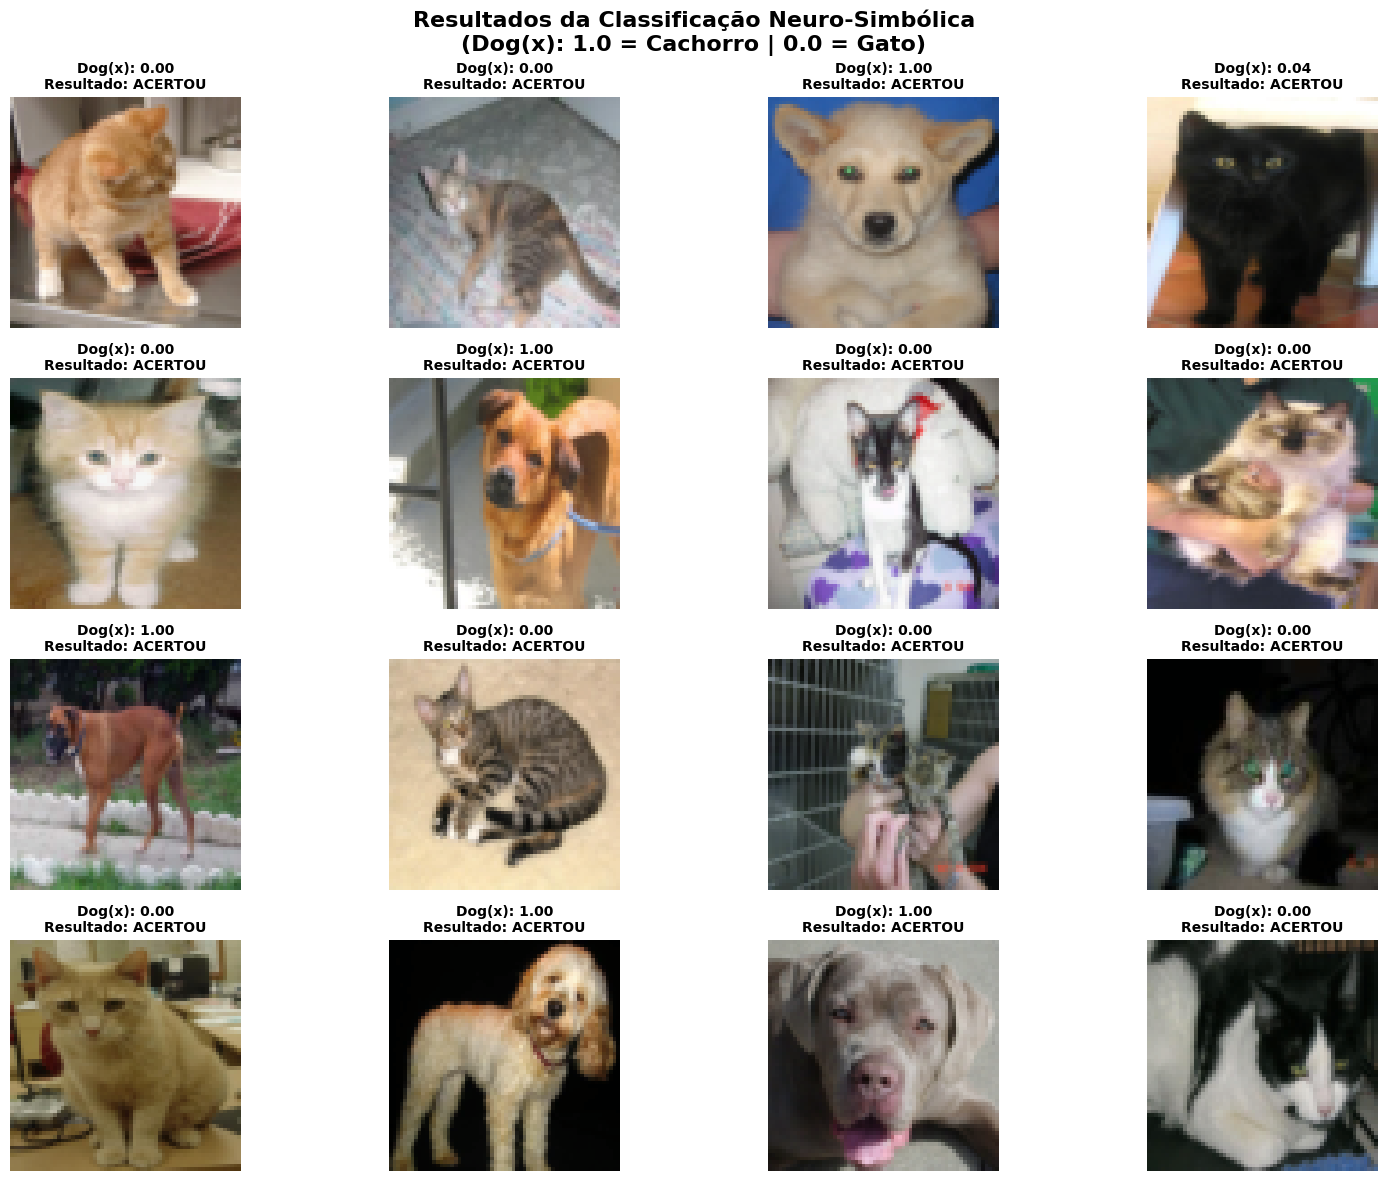

In [17]:
# Visualização em Grade das Predições do Modelo
def visualizar_predicoes_modelo(modelo_cnn, carregador, num_amostras=16):
    """
    Cria uma visualização em grade mostrando imagens com suas predições.
    """
    modelo_cnn.eval()
    
    # Transformação para desfazer a normalização ImageNet para visualização
    denormalize = transforms.Normalize(
        mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
        std=[1/0.229, 1/0.224, 1/0.225]
    )
    
    # Coletar amostras para visualização
    imagens_vis = []
    labels_vis = []
    predicoes_vis = []
    
    with torch.no_grad():
        for imagens_batch, labels_batch in carregador:
            for i in range(len(imagens_batch)):
                if len(imagens_vis) >= num_amostras:
                    break
                    
                # Preparar imagem para predição
                img_tensor = imagens_batch[i].unsqueeze(0).to(ltn.device)
                score = modelo_cnn(img_tensor).item()
                
                # Armazenar dados
                imagens_vis.append(imagens_batch[i])
                labels_vis.append(labels_batch[i].item())
                predicoes_vis.append(score)
                
            if len(imagens_vis) >= num_amostras:
                break
    
    # Configurar grid de visualização
    cols = 4
    rows = num_amostras // cols
    fig, axes = plt.subplots(rows, cols, figsize=(16, 12))
    fig.suptitle('Resultados da Classificação Neuro-Simbólica\n(Dog(x): 1.0 = Cachorro | 0.0 = Gato)', 
                 fontsize=16, fontweight='bold')
    
    for i in range(num_amostras):
        row = i // cols
        col = i % cols
        ax = axes[row, col]
        
        # Preparar imagem para visualização
        img = denormalize(imagens_vis[i])
        img = torch.clamp(img, 0, 1)
        img_np = img.permute(1, 2, 0).numpy()
        
        # Obter predição e label real
        score = predicoes_vis[i]
        label_real = labels_vis[i]
        
        # Verificar se acertou ou errou
        acertou = (label_real == 1 and score > 0.5) or (label_real == 0 and score <= 0.5)
        resultado = "ACERTOU" if acertou else "ERROU"
        
        # Mostrar imagem
        ax.imshow(img_np)
        ax.set_title(f'Dog(x): {score:.2f}\nResultado: {resultado}', 
                    color='black', fontweight='bold', fontsize=10)
        ax.axis('off')
        
        # Adicionar borda colorida baseada no acerto/erro
        for spine in ax.spines.values():
            spine.set_linewidth(3)
            spine.set_color('green' if acertou else 'red')
    
    plt.tight_layout()
    plt.show()
    
    # Calcular estatísticas
    corretos = 0
    for i in range(num_amostras):
        score = predicoes_vis[i]
        label_real = labels_vis[i]
        if (label_real == 1 and score > 0.5) or (label_real == 0 and score <= 0.5):
            corretos += 1
    
    acuracia = corretos / num_amostras


# Executar visualização
if carregador_dados is not None:
    print("Gerando visualização das predições do modelo...")
    visualizar_predicoes_modelo(modelo_cnn, carregador_dados, num_amostras=16)
else:
    print("Dataset não disponível para visualização.")